## CSCI 450 Project 1 | Malek Elaghel
### Particle Physics Event Classification using Computer Vision
### 10/24/2023

### Imports

In [1]:
import os
import numpy as np
from skimage.feature import hog, local_binary_pattern
import matplotlib.pyplot as plt
import cv2
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

### Datapaths

In [2]:
train_path = "ProtonCollision13TeV/Train/"
test_path = "ProtonCollision13TeV/Test/"

### Counting Images in training and testing sets.

In [3]:
def count_images(data_folder):
    total_images = 0
    for class_folder in os.listdir(data_folder):
        class_path = os.path.join(data_folder, class_folder)
        total_images += len(os.listdir(class_path))
    return total_images


# Get the total number of images in the training data
total_training_images = count_images(train_path)
total_testing_images = count_images(test_path)

In [4]:
print(f"Total training images: {total_training_images}Total testing images: {total_testing_images}")



Total training images: 25314
Total testing images: 14074


### Normalize Images

In [5]:
# This also converts grayscale images to RGB with identical channels.
def im_normalize(image):
    if len(image.shape) == 2:
        # Grayscale image, convert to RGB
        image = np.stack((image, image, image), axis=-1)

    # Normalize each channel independently
    for channel in range(image.shape[-1]):
        channel_min = image[..., channel].min()
        channel_max = image[..., channel].max()
        image[..., channel] = (
            (image[..., channel] - channel_min) / (channel_max - channel_min)
        ) * 255

    return image.astype(np.uint8)

In [6]:
os.listdir(train_path)

['QCD', 'TTbar', 'WJets']

### This code initializes variables to store statistics and processes image data. It iterates through class folders, counting images, computing statistics, and generating HOG features.

In [7]:
# Initialize variables to store statistics
max_num_images = 0
min_num_images = float("inf")
max_height = 0
min_height = float("inf")
max_width = 0
min_width = float("inf")

class_folders = os.listdir(train_path)

class_sizes = np.zeros(len(class_folders), dtype=np.int64)

labels = np.zeros((total_training_images), dtype=np.int64)
hogs = np.zeros((total_training_images, 2048))
lbps = np.zeros((total_training_images, 256), dtype=np.int64)  # Assuming a 256-bin LBP


avg_images = np.zeros((len(class_folders), 256, 256, 3), dtype=np.uint8)

for i, class_folder in enumerate(class_folders):
    class_path = os.path.join(train_path, class_folder)
    image_paths = [
        os.path.join(class_path, filename)
        for filename in os.listdir(class_path)
        if filename.lower().endswith((".jpg", ".jpeg", ".png"))
    ]
    num_images = len(os.listdir(class_path))
    class_sizes[i] = num_images
    images = np.zeros(
        (len(image_paths), 256, 256, 3), dtype=np.uint8
    )  # Initialize an empty array to store the images

    # Update statistics
    max_num_images = max(max_num_images, num_images)
    min_num_images = min(min_num_images, num_images)

    print(f"\rClass #{i+1}: {class_folder}. Class size: {class_sizes[i]}")

    for j, image_path in enumerate(image_paths):
        print(
            f"\rProcessing picture number #{j+1} in class #{i+1} out of 3: {class_folder}.",
            end="",
        )
        image = cv2.imread(image_path)
        height, width = image.shape[:2]
        max_height = max(max_height, height)
        min_height = min(min_height, height)
        max_width = max(max_width, width)
        min_width = min(min_width, width)

        # if len(image.shape) == 2:
        #     image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        image = cv2.resize(
            image, (256, 256)
        )  # Normalize the image and store it in the images array
        image = im_normalize(image)  # Resize the image to 256x256 with 3 channels (RGB)
        images[j] = image
        fd = hog(
            image,
            orientations=8,
            pixels_per_cell=(16, 16),
            cells_per_block=(1, 1),
            channel_axis=2,
        )
        # print(fd.shape)
        hogs[sum(class_sizes[:i]) + j] = fd
        # labels[sum(class_sizes[:i]) + j] = i # Works!

    labels[sum(class_sizes[:i]) : sum(class_sizes[:i]) + j + 1] = i
    print(
        f"\r\nThere were {j+1} images in class {i+1} out of {len(class_folders)}: {class_folder}. This is {sum(class_sizes[:i]) + j + 1} images in total."
    )
    avg_images[i] = (
        np.mean(images, axis=0)
        if images.any()
        else np.zeros((256, 256, 3), dtype=np.uint8)
    )
    print(
        f"\rProcessed class {i+1} of {len(class_folders)}: {class_folder}, successfully!"
    )

Class #1: QCD. Class size: 8439
Processing picture number #8439 in class #1 out of 3: QCD.
There were 8439 images in class 1 out of 3: QCD. This is 8439 images in total. 
Processed class 1 of 3: QCD, successfully!
Class #2: TTbar. Class size: 8431
Processing picture number #8431 in class #2 out of 3: TTbar.
There were 8431 images in class 2 out of 3: TTbar. This is 16870 images in total. 
Processed class 2 of 3: TTbar, successfully!
Class #3: WJets. Class size: 8444
Processing picture number #8444 in class #3 out of 3: WJets.
There were 8444 images in class 3 out of 3: WJets. This is 25314 images in total. 
Processed class 3 of 3: WJets, successfully!


### This is just a test to check if all labels are assigned properly, i.e., matching the class sizes.

In [8]:
for i in range(3):
    print(sum(labels == i))

8439
8431
8444


### Training Set Statistics:

In [9]:
print(f"Maximum number of images in a class: {max_num_images}")
print(f"Minimum number of images in a class: {min_num_images}")
print(f"Maximum height of an image: {max_height}")
print(f"Minimum height of an image: {min_height}")
print(f"Maximum width of an image: {max_width}")
print(f"Minimum width of an image: {min_width}")

Maximum number of images in a class: 8444
Minimum number of images in a class: 8431
Maximum height of an image: 372
Minimum height of an image: 372
Maximum width of an image: 1196
Minimum width of an image: 1196


#### Max = Min => all images have the same size (372x1196).

### Training Set Average Images.

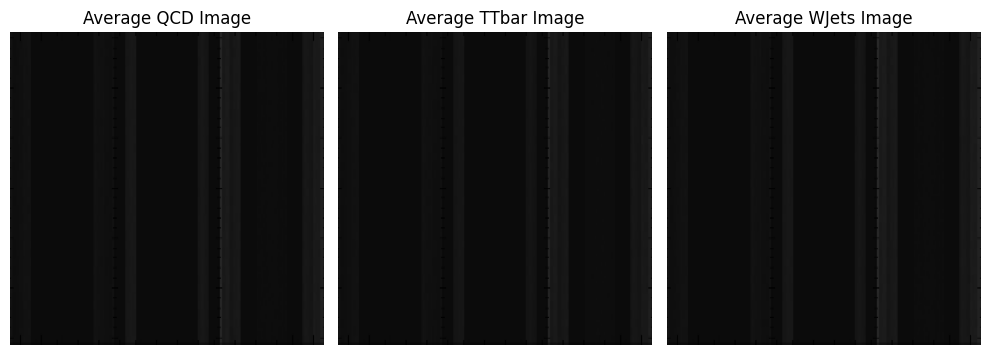

In [10]:
titles = class_folders

# Create a single row of subplots
fig, axes = plt.subplots(1, len(avg_images), figsize=(10, 5))

# Iterate through images and titles, displaying them in subplots:
for ax, img, title in zip(axes, avg_images, titles):
    ax.imshow(img, "gray")
    ax.set_title(f"Average {title} Image")
    ax.axis("off")
plt.tight_layout()
plt.show()

### The images above represent the distribution of the particles detected in the training set.

### Check if the average images are the same or not, as they're visually hard to distinguish

In [11]:
# Check if there are any equal/exact images
any((avg_images[i] == avg_images[j]).all() for i in range(3) for j in range(i + 1, 3))

False

### Check if the HOG features are recorded properly (not empty).

In [12]:
hogs.any()

True

### Extracting HOG features from the test data.

In [13]:
test_class_folders = os.listdir(test_path)

test_class_sizes = np.zeros(len(test_class_folders), dtype=np.int64)

test_labels = np.zeros((total_testing_images), dtype=np.int64)
test_hogs = np.zeros((total_testing_images, 2048))

# test_avg_images = np.zeros((len(test_class_folders), 256, 256, 3), dtype=np.uint8)

for i, test_class_folder in enumerate(test_class_folders):
    test_class_path = os.path.join(test_path, test_class_folder)
    test_image_paths = [
        os.path.join(test_class_path, test_filename)
        for test_filename in os.listdir(test_class_path)
        if test_filename.lower().endswith((".jpg", ".jpeg", ".png"))
    ]
    test_num_images = len(os.listdir(test_class_path))
    test_class_sizes[i] = test_num_images
    test_images = np.zeros(
        (len(test_image_paths), 256, 256, 3), dtype=np.uint8
    )  # Initialize an empty array to store the images

    print(f"\rClass #{i+1}: {test_class_folder}. Class size: {test_class_sizes[i]}")

    for j, test_image_path in enumerate(test_image_paths):
        print(
            f"\rProcessing picture number #{j+1} in class #{i+1} out of 3: {test_class_folder}.",
            end="",
        )
        image = cv2.imread(test_image_path)
        # height, width = image.shape[:2]
        # max_height = max(max_height, height)
        # min_height = min(min_height, height)
        # max_width = max(max_width, width)
        # min_width = min(min_width, width)

        # if len(image.shape) == 2:
        #     image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        image = cv2.resize(
            image, (256, 256)
        )  # Normalize the image and store it in the images array
        image = im_normalize(image)  # Resize the image to 256x256 with 3 channels (RGB)
        test_images[j] = image
        test_fd = hog(
            image,
            orientations=8,
            pixels_per_cell=(16, 16),
            cells_per_block=(1, 1),
            channel_axis=2,
        )
        # print(fd.shape)
        test_hogs[sum(test_class_sizes[:i]) + j] = test_fd
        # labels[sum(class_sizes[:i]) + j] = i # Works!

    test_labels[sum(test_class_sizes[:i]) : sum(test_class_sizes[:i]) + j + 1] = i
    print(
        f"\r\nThere were {j+1} images in class {i+1} out of {len(test_class_folders)}: {test_class_folder}. This is {sum(test_class_sizes[:i]) + j + 1} images in total. "
    )
    # test_avg_images[i] = np.mean(test_images, axis=0) if test_images.any() else np.zeros((256, 256, 3), dtype=np.uint8)
    print(
        f"\rProcessed class {i+1} of {len(test_class_folders)}: {test_class_folder}, successfully!"
    )

Class #1: QCD. Class size: 4692
Processing picture number #4692 in class #1 out of 3: QCD.
There were 4692 images in class 1 out of 3: QCD. This is 4692 images in total. 
Processed class 1 of 3: QCD, successfully!
Class #2: TTbar. Class size: 4691
Processing picture number #4691 in class #2 out of 3: TTbar.
There were 4691 images in class 2 out of 3: TTbar. This is 9383 images in total. 
Processed class 2 of 3: TTbar, successfully!
Class #3: WJets. Class size: 4691
Processing picture number #4691 in class #3 out of 3: WJets.
There were 4691 images in class 3 out of 3: WJets. This is 14074 images in total. 
Processed class 3 of 3: WJets, successfully!


### Assigning the HOG features and labels to standard variable names.

In [14]:
X_train, y_train, X_test, y_test = hogs, labels, test_hogs, test_labels

### Random Forest Classifier

In [15]:
RFmodel = RandomForestClassifier()
RFmodel.fit(X_train, y_train)
RFmodel_pred = RFmodel.predict(X_test)
RFmodel_acc = accuracy_score(y_test, RFmodel_pred)

0.4657524513286912

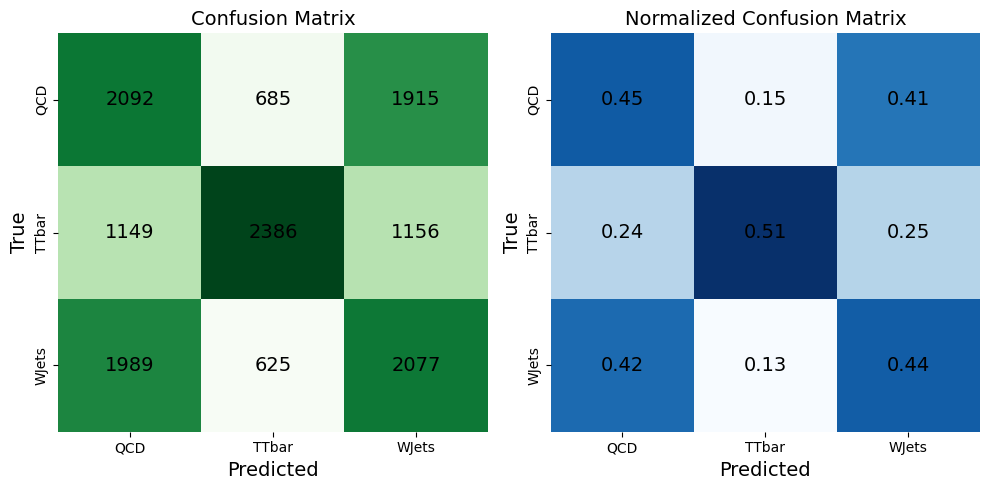

In [16]:
cmlabels = np.unique(y_test)
cmlabel_ticks = class_folders

# Compute the confusion matrix and normalized confusion matrix
cm = confusion_matrix(y_test, RFmodel_pred, labels=cmlabels)
cm_norm = confusion_matrix(y_test, RFmodel_pred, labels=cmlabels, normalize="true")

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the confusion matrix
sns.heatmap(
    cm,
    annot=True,
    cmap="Greens",
    xticklabels=cmlabel_ticks,
    yticklabels=cmlabel_ticks,
    fmt="d",
    cbar=False,
    ax=axs[0],
    annot_kws={"fontsize": 14, "color": "black"},
)
axs[0].set_xlabel("Predicted", fontsize=14)
axs[0].set_ylabel("True", fontsize=14)
axs[0].set_title("Confusion Matrix", fontsize=14)

# Plot the normalized confusion matrix
sns.heatmap(
    cm_norm,
    annot=True,
    cmap="Blues",
    xticklabels=cmlabel_ticks,
    yticklabels=cmlabel_ticks,
    fmt=".2f",
    cbar=False,
    ax=axs[1],
    annot_kws={"fontsize": 14, "color": "black"},
)
axs[1].set_xlabel("Predicted", fontsize=14)
axs[1].set_ylabel("True", fontsize=14)
axs[1].set_title("Normalized Confusion Matrix", fontsize=14)

plt.tight_layout()

### Random Forest Classifier with PCA.

In [17]:
# Apply PCA to reduce dimensionality
pca = PCA(n_components=100)  # Adjust the number of components as needed
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [18]:
# Create and fit the Random Forest model
RFmodel.fit(X_train_pca, y_train)

# Predict and calculate accuracy
RFmodel_pred_pca = RFmodel.predict(X_test_pca)
RFmodel_acc_pca = accuracy_score(y_test, RFmodel_pred_pca)

### Difference berween PCA and no PCA.

In [19]:
RFmodel_acc_pca - RFmodel_acc

-0.053360807162142976

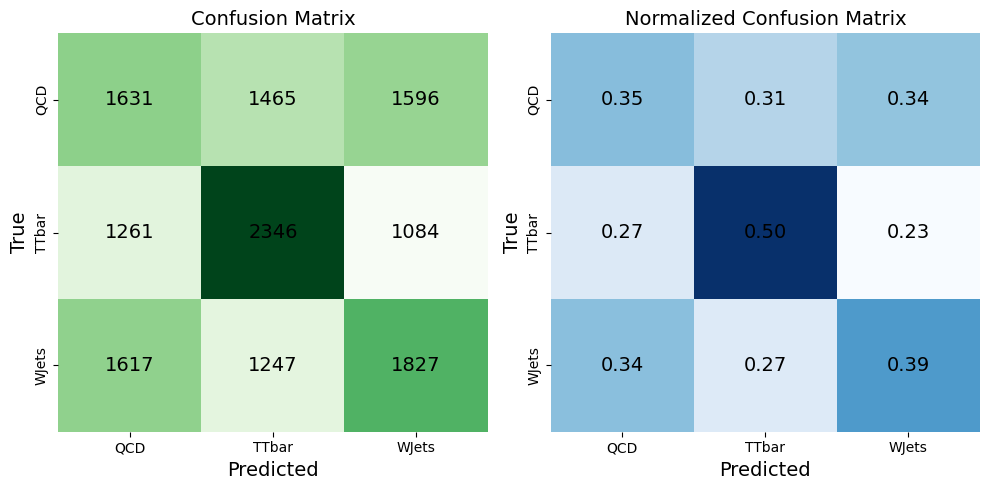

In [20]:
cmlabels = np.unique(y_test)
cmlabel_ticks = class_folders

# Compute the confusion matrix and normalized confusion matrix
cm = confusion_matrix(y_test, RFmodel_pred_pca, labels=cmlabels)
cm_norm = confusion_matrix(y_test, RFmodel_pred_pca, labels=cmlabels, normalize="true")

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the confusion matrix
sns.heatmap(
    cm,
    annot=True,
    cmap="Greens",
    xticklabels=cmlabel_ticks,
    yticklabels=cmlabel_ticks,
    fmt="d",
    cbar=False,
    ax=axs[0],
    annot_kws={"fontsize": 14, "color": "black"},
)
axs[0].set_xlabel("Predicted", fontsize=14)
axs[0].set_ylabel("True", fontsize=14)
axs[0].set_title("Confusion Matrix", fontsize=14)

# Plot the normalized confusion matrix
sns.heatmap(
    cm_norm,
    annot=True,
    cmap="Blues",
    xticklabels=cmlabel_ticks,
    yticklabels=cmlabel_ticks,
    fmt=".2f",
    cbar=False,
    ax=axs[1],
    annot_kws={"fontsize": 14, "color": "black"},
)
axs[1].set_xlabel("Predicted", fontsize=14)
axs[1].set_ylabel("True", fontsize=14)
axs[1].set_title("Normalized Confusion Matrix", fontsize=14)

plt.tight_layout()

### Linear SVM Classifier

In [21]:
SVMmodel = LinearSVC(dual=True)

In [22]:
SVMmodel.fit(X_train, y_train)
SVMmodel_pred = SVMmodel.predict(X_test)
SVMmodel_acc = accuracy_score(y_test, SVMmodel_pred)

c:\Users\malek\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [26]:
SVMmodel_acc

0.48564729288048886

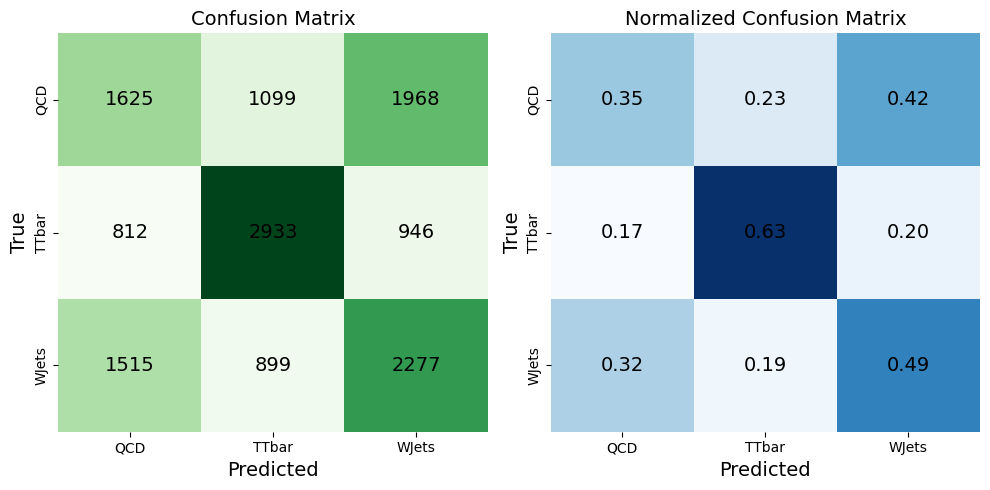

In [24]:
cmlabels = np.unique(y_test)
cmlabel_ticks = class_folders

# Compute the confusion matrix and normalized confusion matrix
cm = confusion_matrix(y_test, SVMmodel_pred, labels=cmlabels)
cm_norm = confusion_matrix(y_test, SVMmodel_pred, labels=cmlabels, normalize="true")

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the confusion matrix
sns.heatmap(
    cm,
    annot=True,
    cmap="Greens",
    xticklabels=cmlabel_ticks,
    yticklabels=cmlabel_ticks,
    fmt="d",
    cbar=False,
    ax=axs[0],
    annot_kws={"fontsize": 14, "color": "black"},
)
axs[0].set_xlabel("Predicted", fontsize=14)
axs[0].set_ylabel("True", fontsize=14)
axs[0].set_title("Confusion Matrix", fontsize=14)

# Plot the normalized confusion matrix
sns.heatmap(
    cm_norm,
    annot=True,
    cmap="Blues",
    xticklabels=cmlabel_ticks,
    yticklabels=cmlabel_ticks,
    fmt=".2f",
    cbar=False,
    ax=axs[1],
    annot_kws={"fontsize": 14, "color": "black"},
)
axs[1].set_xlabel("Predicted", fontsize=14)
axs[1].set_ylabel("True", fontsize=14)
axs[1].set_title("Normalized Confusion Matrix", fontsize=14)

plt.tight_layout()

### Linear SVM Classifier with PCA.

In [28]:
# Create and fit the Support Vector Machine model
SVMmodel.fit(X_train_pca, y_train)

# Predict and calculate accuracy
SVMmodel_pred_pca = SVMmodel.predict(X_test_pca)
SVMmodel_acc_pca = accuracy_score(y_test, SVMmodel_pred_pca)

c:\Users\malek\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### Difference berween PCA and no PCA.

In [29]:
SVMmodel_acc_pca - SVMmodel_acc

-0.055847662356117656

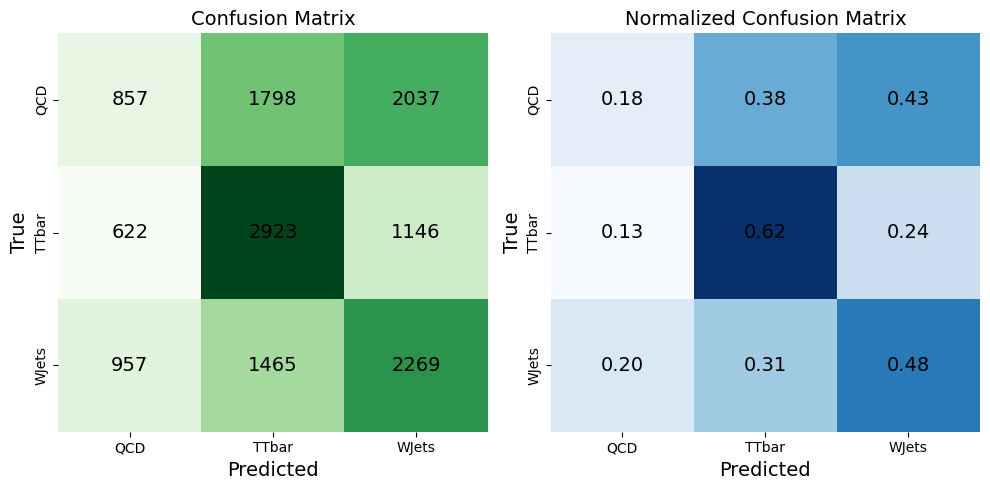

In [30]:

cmlabels = np.unique(y_test)
cmlabel_ticks = class_folders

# Compute the confusion matrix and normalized confusion matrix
cm = confusion_matrix(y_test, SVMmodel_pred_pca, labels=cmlabels)
cm_norm = confusion_matrix(y_test, SVMmodel_pred_pca, labels=cmlabels, normalize="true")

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the confusion matrix
sns.heatmap(
    cm,
    annot=True,
    cmap="Greens",
    xticklabels=cmlabel_ticks,
    yticklabels=cmlabel_ticks,
    fmt="d",
    cbar=False,
    ax=axs[0],
    annot_kws={"fontsize": 14, "color": "black"},
)
axs[0].set_xlabel("Predicted", fontsize=14)
axs[0].set_ylabel("True", fontsize=14)
axs[0].set_title("Confusion Matrix", fontsize=14)

# Plot the normalized confusion matrix
sns.heatmap(
    cm_norm,
    annot=True,
    cmap="Blues",
    xticklabels=cmlabel_ticks,
    yticklabels=cmlabel_ticks,
    fmt=".2f",
    cbar=False,
    ax=axs[1],
    annot_kws={"fontsize": 14, "color": "black"},
)
axs[1].set_xlabel("Predicted", fontsize=14)
axs[1].set_ylabel("True", fontsize=14)
axs[1].set_title("Normalized Confusion Matrix", fontsize=14)

plt.tight_layout()

## Not important, but was helpful with troubleshooting.

         197535 function calls (192090 primitive calls) in 0.214 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    0.140    0.070 matrix.py:355(heatmap)
        2    0.000    0.000    0.137    0.069 matrix.py:294(plot)
        2    0.000    0.000    0.113    0.056 utils.py:81(_draw_figure)
        2    0.000    0.000    0.113    0.056 backend_agg.py:381(draw)
        2    0.000    0.000    0.111    0.056 artist.py:93(draw_wrapper)
    272/2    0.001    0.000    0.111    0.056 artist.py:54(draw_wrapper)
        2    0.000    0.000    0.111    0.056 figure.py:3134(draw)
      6/2    0.000    0.000    0.109    0.055 image.py:114(_draw_list_compositing_images)
        4    0.000    0.000    0.109    0.027 _base.py:3005(draw)
        8    0.000    0.000    0.085    0.011 axis.py:1379(draw)
      170    0.002    0.000    0.041    0.000 text.py:915(get_window_extent)
      186    0.006    0.000    0.

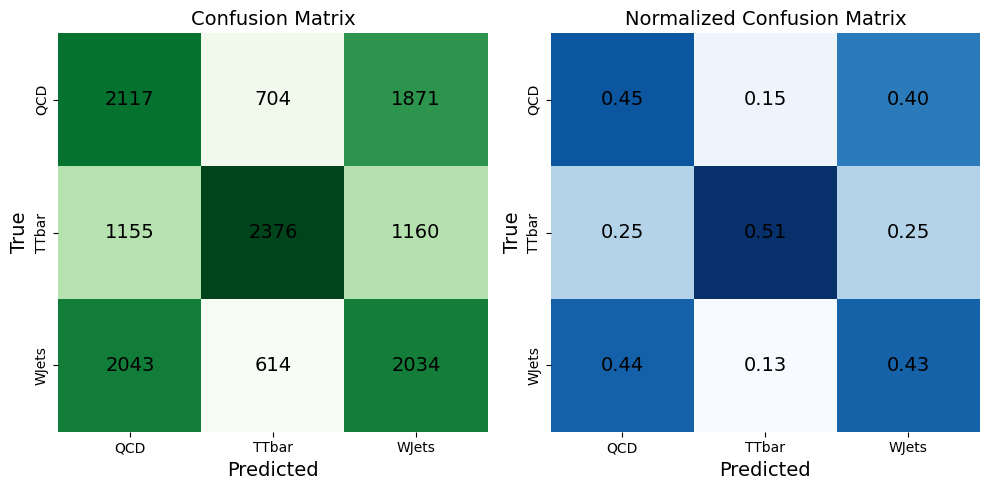

In [169]:
# import cProfile

# def plot_confusion_matrix():
#     cmlabels = np.unique(y_test)
#     cmlabel_ticks = class_folders

#     # Compute the confusion matrix and normalized confusion matrix
#     cm = confusion_matrix(y_test, RFmodel_pred, labels=cmlabels)
#     cm_norm = confusion_matrix(y_test, RFmodel_pred, labels=cmlabels, normalize="true")

#     fig, axs = plt.subplots(1, 2, figsize=(10, 5))

#     # Plot the confusion matrix
#     sns.heatmap(
#         cm,
#         annot=True,
#         cmap="Greens",
#         xticklabels=cmlabel_ticks,
#         yticklabels=cmlabel_ticks,
#         fmt="d",
#         cbar=False,
#         ax=axs[0],
#         annot_kws={"fontsize": 14, "color": "black"},
#     )
#     axs[0].set_xlabel("Predicted", fontsize=14)
#     axs[0].set_ylabel("True", fontsize=14)
#     axs[0].set_title("Confusion Matrix", fontsize=14)

#     # Plot the normalized confusion matrix
#     sns.heatmap(
#         cm_norm,
#         annot=True,
#         cmap="Blues",
#         xticklabels=cmlabel_ticks,
#         yticklabels=cmlabel_ticks,
#         fmt=".2f",
#         cbar=False,
#         ax=axs[1],
#         annot_kws={"fontsize": 14, "color": "black"},
#     )
#     axs[1].set_xlabel("Predicted", fontsize=14)
#     axs[1].set_ylabel("True", fontsize=14)
#     axs[1].set_title("Normalized Confusion Matrix", fontsize=14)

#     plt.tight_layout()

# if __name__ == "__main__":
#     cProfile.run("plot_confusion_matrix()", sort='cumulative')

In [ ]:
# # Initialize variables to store statistics
# max_num_images = 0
# min_num_images = float('inf')
# max_height = 0
# min_height = float('inf')
# max_width = 0
# min_width = float('inf')


# class_folders = os.listdir(train_path)

# class_sizes = np.zeros(len(class_folders), dtype=np.int64)

# labels = np.zeros((total_training_images), dtype=np.int64)
# hogs = np.zeros((total_training_images, 2048), dtype=np.uint8)

# avg_images = np.zeros((len(class_folders), 256, 256, 3), dtype=np.uint8)

# for i, class_folder in enumerate(class_folders):
#     class_path = os.path.join(train_path, class_folder)
#     image_paths = [os.path.join(class_path, filename) for filename in os.listdir(class_path) if filename.lower().endswith(('.jpg', '.jpeg', '.png'))]
#     num_images = len(os.listdir(class_path))
#     class_sizes[i] = num_images
#     images = np.zeros((len(image_paths), 256, 256, 3), dtype=np.uint8) # Initialize an empty array to store the images


#     # # Update statistics
#     # max_num_images = max(max_num_images, num_images)
#     # min_num_images = min(min_num_images, num_images)


#     # print(f"\rClass #{i+1}: {class_folder}. Class size: {class_sizes[i]}")

#     for j, image in enumerate(images):
#         # print(f"\rProcessing picture number #{j+1} in class #{i+1} out of 3: {class_folder}.", end='')
#         # image = cv2.imread(image_path)
#         # height, width = image.shape[:2]
#         # max_height = max(max_height, height)
#         # min_height = min(min_height, height)
#         # max_width = max(max_width, width)
#         # min_width = min(min_width, width)

#         # # if len(image.shape) == 2:
#         # #     image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
#         # image = cv2.resize(image, (256, 256))  # Normalize the image and store it in the images array
#         # image = im_normalize(image) # Resize the image to 256x256 with 3 channels (RGB)
#         # images[j] = image
#         # fd = hog(image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), channel_axis=2)
#         # # print(fd.shape)
#         # hogs[i * len(class_sizes[:i]) + j] = fd
#         # labels[i * num_images + j] = i
#         print(sum(class_sizes[:i]) + j)

# #     avg_images[i] = np.mean(images, axis=0) if images.any() else np.zeros((256, 256, 3), dtype=np.uint8)
# #     print(f'\rProcessed class {i+1} of {len(class_folders)}: {class_folder}, successfully!', end='\n')

# # print(i * sum(class_sizes[:i]) - i + j)

In [ ]:
# # Initialize variables to store statistics
# class_folders = os.listdir(train_path)
# class_sizes = np.zeros(len(class_folders), dtype=np.int64)

# labels = np.zeros((total_training_images), dtype=np.int64)
# hogs = np.zeros((total_training_images, 2048), dtype=np.uint8)

# avg_images = np.zeros((len(class_folders), 256, 256, 3), dtype=np.uint8)

# for i, class_folder in enumerate(class_folders):
#     class_path = os.path.join(train_path, class_folder)
#     image_paths = [os.path.join(class_path, filename) for filename in os.listdir(class_path) if filename.lower().endswith(('.jpg', '.jpeg', '.png'))]
#     images = [transform.resize(io.imread(image_path), (256, 256, 3), anti_aliasing=True) for image_path in image_paths]

#     num_images = len(images)
#     class_sizes[i] = num_images
#     print(f"Class #{i+1}: {class_folder}. Class size: {class_sizes[i]}")

#     for j, image in enumerate(images):
#         height, width = image.shape[:2]
#         print(f"\rProcessing picture number #{j+1} in class #{i+1}: {class_folder}.", end='')

#         if len(image.shape) == 2:
#             image = np.stack((image, image, image), axis=-1)

#         fd = hog(image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), channel_axis=2)
#         hogs[i * num_images + j] = fd
#         labels[i * num_images + j] = i

#     avg_images[i] = np.mean(images, axis=0) if images else np.zeros((256, 256, 3), dtype=np.uint8)
#     print(f'\rProcessed class {i+1} of {len(class_folders)}: {class_folder}, successfully!', end='')

In [ ]:
# # Initialize variables to store statistics
# max_num_images = 0
# min_num_images = float('inf')
# max_height = 0
# min_height = float('inf')
# max_width = 0
# min_width = float('inf')

# # HOG parameters
# orientations = 8
# pixels_per_cell = (16, 16)
# cells_per_block = (1, 1)


# # Get the names of the class folders in the training data
# class_folders = os.listdir(train_path)
# # Initialize an array to store the number of images in each class
# class_sizes = np.zeros(len(class_folders), dtype=np.int64)

# # Initialize arrays to store the labels and HOG features
# labels = np.zeros((total_training_images), dtype=np.int64)
# hogs = np.zeros((total_training_images, 2048), dtype=np.uint8)


# # Initialize a list to store average images as NumPy arrays. Use zeros as a safety net, although it's slower than pre-allocating with np.empty().
# avg_images = np.zeros((len(class_folders), 256, 256, 3), dtype=np.uint8)

# # Loop through all the folders in the path.
# for i, class_folder in enumerate(class_folders):
#     # Get the path of the class folder
#     class_path = os.path.join(train_path, class_folder)
#     num_images = len(os.listdir(class_path))
#     class_sizes[i] = num_images
#     print(f"Class #{i+1}: {class_folder}. Class size: {class_sizes[i]}")

#     # Update statistics
#     max_num_images = max(max_num_images, num_images)
#     min_num_images = min(min_num_images, num_images)

#     # Collect image files, read them, and resize to 256x256
#     image_paths = [os.path.join(class_path, filename) for filename in os.listdir(class_path) if filename.lower().endswith(('.jpg', '.jpeg', '.png'))] # Get the path of the image files in the class folder
#     images = np.zeros((len(image_paths), 256, 256, 3), dtype=np.uint8) # Initialize an empty array to store the images

#     for j, image_path in enumerate(image_paths): # Loop through all the images in the class folder
#         image = io.imread(image_path)
#         height, width = image.shape[:2]
#         max_height = max(max_height, height)
#         min_height = min(min_height, height)
#         max_width = max(max_width, width)
#         min_width = min(min_width, width)
#         line = f"\rProcessing picture number #{j+1} in class #{i+1}: {class_folder}."
#         print(line, end='')
#         # I had to resize before normalizing because; otherwise, the output is a black image.
#         # So, while I know the images are grayscale, I think they are being read as RGB anyway, but this is but a safety net to insure they can get resized properly.
#         if len(image.shape) == 2:
#             image = np.stack((image, image, image), axis=-1)
#         image = transform.resize(image, (256, 256, 3), anti_aliasing=True)  # Normalize the image and store it in the images array
#         image = im_normalize(image) # Resize the image to 256x256 with 3 channels (RGB)
#         # Extract HOG features from the image
#         images[i * num_images + j] = image
#         fd = hog(image, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, channel_axis=2)
#         hogs[i * num_images + j] = fd
#         labels[i * num_images + j] = i

#     # Calculate the average image for this class as a NumPy array
#     if images: # If there are images in the class folder
#         avg_image = np.mean(images, axis=0)
#         avg_images[i] = avg_image
#         line = f'\rProcessed class {i+1} of {len(class_folders)}: {class_folder}, successfully!'
#         print(line, end='')